# Introduction and Setup



Image colorization using a paired image-to-image translation network : Pix2pix

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import ImageDraw


AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2.5.0


# Load in the data

Our data are 10.000  256x256 images downloaded from kaggle in the TFRecord format.
https://www.kaggle.com/c/gan-getting-started/data

In [6]:
DATA_PATH= 'data'

In [7]:

PHOTO_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.



Also since images are colored, during loading I transformed them to gray scale and then filled the remaining two channels with a gaussian noise which led to better results.

In [8]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def decode_image_gray(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.image.rgb_to_grayscale(image)
    filling=tf.random.normal((256,256,2), mean=0.0, stddev=0.05, dtype=tf.dtypes.float32, seed=None, name=None)
    image = tf.concat([image,filling],axis=2)
    #adding gaussian noise in missing channels
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    gray_image=decode_image_gray(example['image'])
    return gray_image,image


Define the function to extract the image from the files.

In [9]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset



Let's load in our datasets.

In [10]:
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)

In [11]:
example = next(iter(photo_ds))


Let's  visualize a photo example 

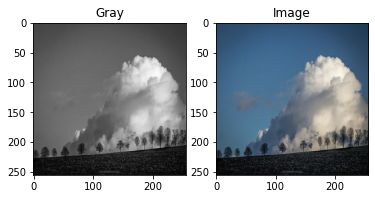

In [12]:
plt.subplot(121)
plt.title('Gray')
plt.imshow(example[0][0][:,:,0] * 0.5 + 0.5,cmap="gray")

plt.subplot(122)
plt.title('Image')
plt.imshow(example[1][0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our GAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [14]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [22]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

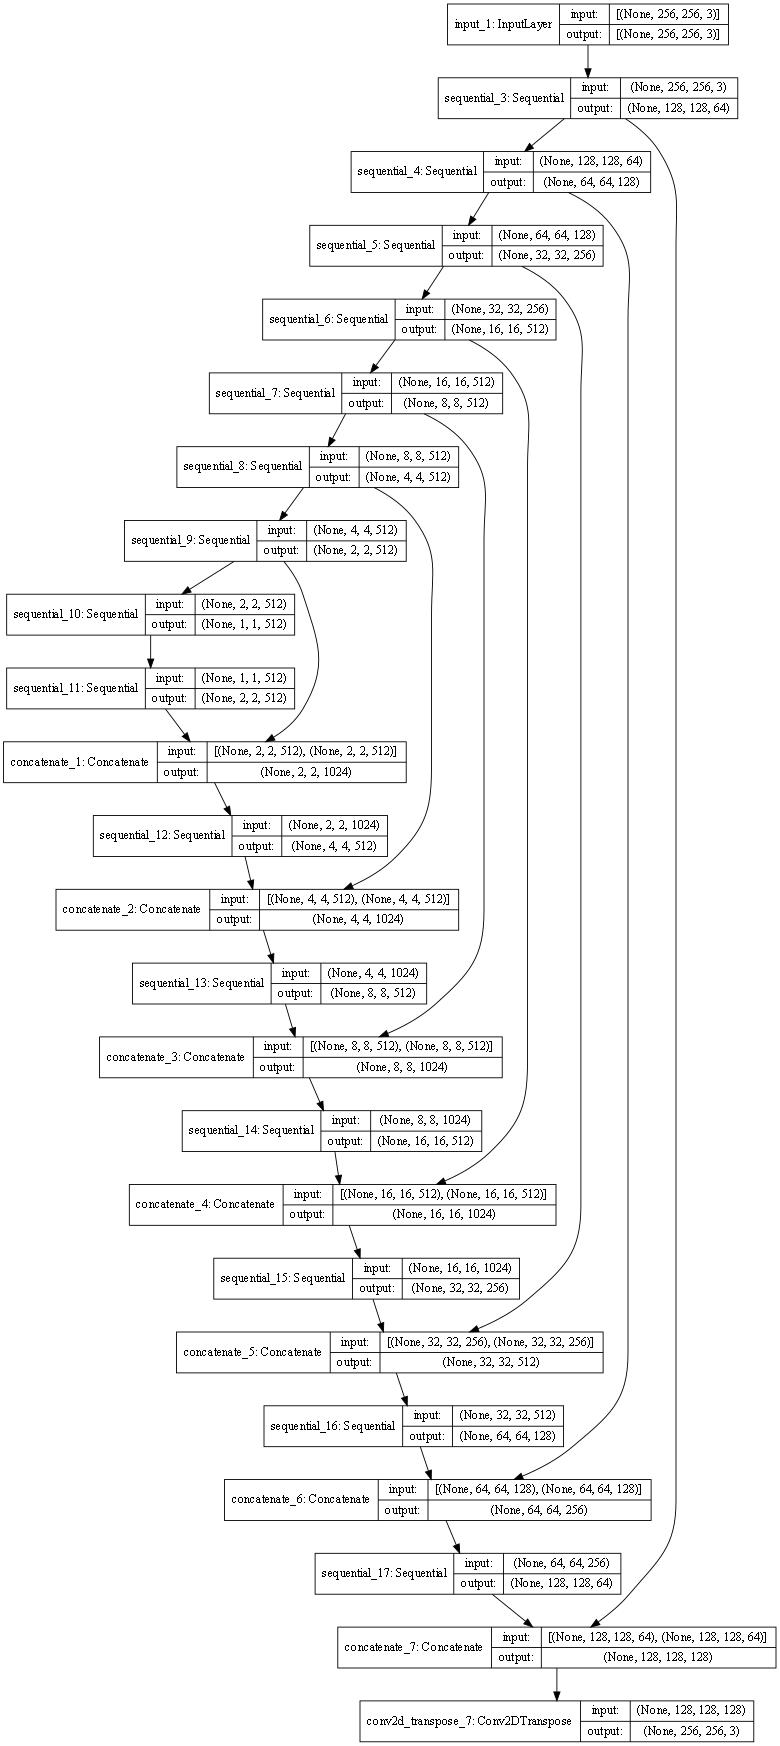

In [23]:
g=Generator()
tf.keras.utils.plot_model(g, show_shapes=True, dpi=64)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification, it is also called a PatchGAN.

In [24]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.ReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(3, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

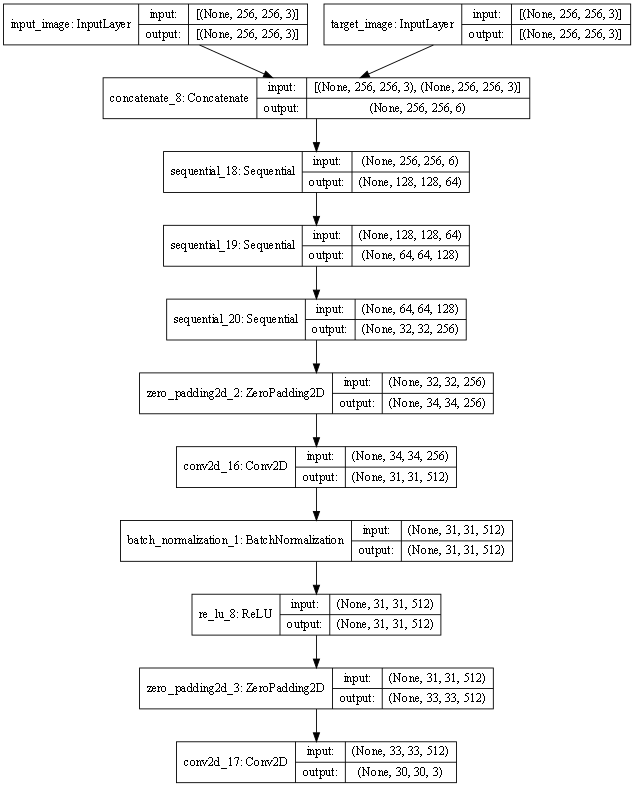

In [25]:
d=Discriminator()
tf.keras.utils.plot_model(d, show_shapes=True, dpi=64)

In [26]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean squared error
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output)**2)

    total_gen_loss = gan_loss + (LAMBDA * l2_loss)

    return total_gen_loss, gan_loss, l2_loss

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [50]:
generator=Generator()
discriminator=Discriminator()

Since our generators are not trained yet, the generated photos does not show what is expected at this point.

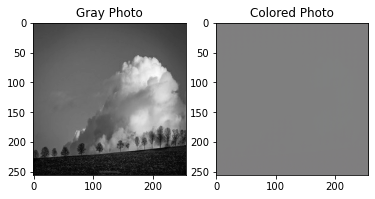

In [51]:
to_color = generator(example[0])

plt.subplot(1, 2, 1)
plt.title("Gray Photo")
plt.imshow(example[0][0][:,:,0] * 0.5 + 0.5,cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Colored Photo")
plt.imshow(to_color[0] * 0.5 + 0.5)
plt.show()

# Build the Pix2pix model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model.

In [33]:
class Pix2pixGan(keras.Model):
    def __init__(
        self,
        generator,
        discriminator,
        count
        
    ):
        super(Pix2pixGan, self).__init__()
        self.generator = generator
        
        self.discriminator = discriminator
        self.count=count
        
        
    def compile(
        self,
        generator_optimizer,
        discriminator_optimizer,
        generator_loss,
        discriminator_loss
    ):
        super(Pix2pixGan, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        
        
    def train_step(self, batch_data):
        input_image, target = batch_data
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)
            if(self.count%10==0):
                disc_real_output = self.discriminator([input_image, target], training=True)
                disc_generated_output = self.discriminator([input_image, gen_output], training=True)
            else:
                disc_real_output = self.discriminator([input_image, target], training=False)
                disc_generated_output = self.discriminator([input_image, gen_output], training=False)
            self.count+=1
            gen_total_loss, gen_gan_loss, gen_l2_loss = self.generator_loss(disc_generated_output, gen_output, target)
            disc_loss = self.discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(generator_gradients,
                                              self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  self.discriminator.trainable_variables))


        return {
            'gen_total_loss': gen_total_loss,
            'gen_gan_loss': gen_gan_loss,
            'gen_l2_loss': gen_l2_loss,
            'disc_loss': disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [34]:
gan_model = Pix2pixGan(
    generator, discriminator,0
)

gan_model.compile(
    generator_optimizer = generator_optimizer,
    
    discriminator_optimizer = discriminator_optimizer,
    generator_loss = generator_loss,
    discriminator_loss = discriminator_loss,
    
)



Checkpoints for model training

In [35]:
checkpoint_filepath = 'checkpoint_color.h5'
checkpoint_filepath = 'checkpoint_color_2.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                monitor="gen_total_loss",
                                                 save_weights_only=True,
                                                 verbose=1)






## Loading a trained model

In [36]:
gan_model.built=True
gan_model.load_weights(checkpoint_filepath)

## Callback function to show visual progress during training

In [38]:
examples = photo_ds.batch(4)
example_photo = next(iter(examples))



 

class ShowExamples(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print("5 generated examples")
        plt.figure(figsize=(12,6))
        for i in range(4):
            plt.subplot(250+i+1)
            plt.title('Real photo '+str(i+1))
            plt.imshow(example_photo[0][i][0][:,:,0] * 0.5 + 0.5,cmap="gray")
            plt.subplot(250+i+6)
            plt.title('Colored photo '+str(i+1))
            g=generator(example_photo[0][i],training=False)[0].numpy()
            g=(g * 127.5 + 127.5).astype(np.uint8)
            plt.imshow(g)
#             im = PIL.Image.fromarray(g)
#             im.save("train_examples/" + str(epoch)+str(i) + ".jpg")
            
        plt.show()

Epoch 1/18
100/100 [==============================] - 39s 392ms/step - gen_total_loss: 6.8424 - gen_gan_loss: 1.6610 - gen_l1_loss: 0.0518 - disc_loss: 0.7875

Epoch 00001: saving model to checkpoint_color.h5
5 generated examples


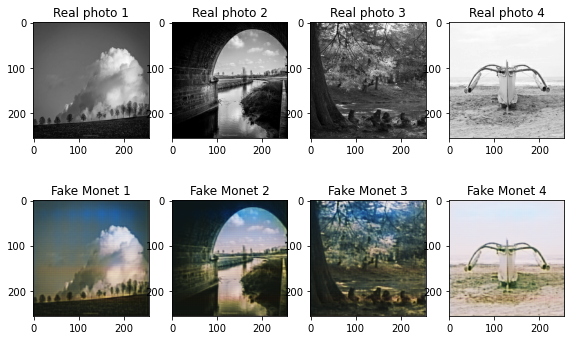

Epoch 2/18
100/100 [==============================] - 46s 458ms/step - gen_total_loss: 8.4012 - gen_gan_loss: 1.8126 - gen_l1_loss: 0.0659 - disc_loss: 0.7529

Epoch 00002: saving model to checkpoint_color.h5
5 generated examples


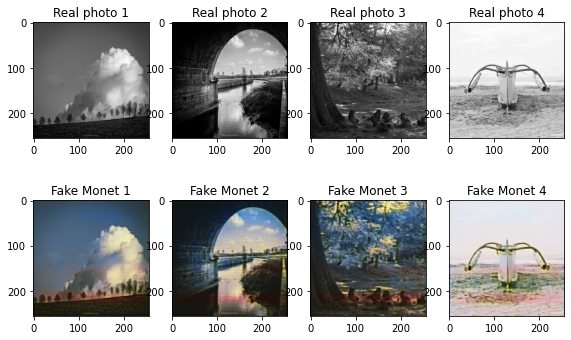

Epoch 3/18
100/100 [==============================] - 42s 418ms/step - gen_total_loss: 6.3391 - gen_gan_loss: 1.5623 - gen_l1_loss: 0.0478 - disc_loss: 0.8038

Epoch 00003: saving model to checkpoint_color.h5
5 generated examples


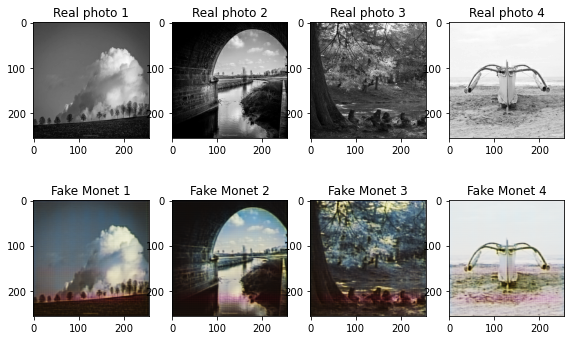

Epoch 4/18
100/100 [==============================] - 43s 429ms/step - gen_total_loss: 7.0587 - gen_gan_loss: 1.7792 - gen_l1_loss: 0.0528 - disc_loss: 0.8224

Epoch 00004: saving model to checkpoint_color.h5
5 generated examples


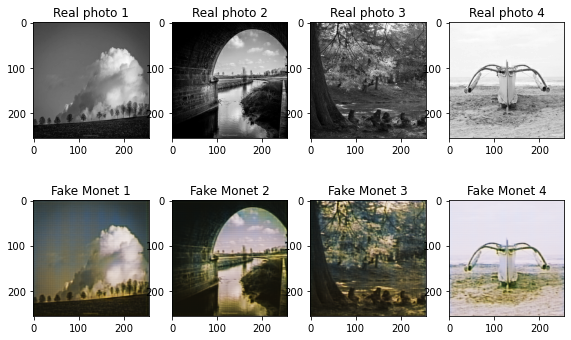

Epoch 5/18
100/100 [==============================] - 49s 494ms/step - gen_total_loss: 7.3281 - gen_gan_loss: 1.8083 - gen_l1_loss: 0.0552 - disc_loss: 0.8170

Epoch 00005: saving model to checkpoint_color.h5
5 generated examples


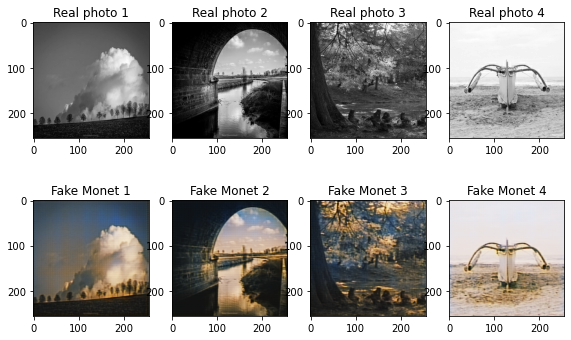

Epoch 6/18
100/100 [==============================] - 50s 495ms/step - gen_total_loss: 6.2659 - gen_gan_loss: 1.7213 - gen_l1_loss: 0.0454 - disc_loss: 0.7303

Epoch 00006: saving model to checkpoint_color.h5
5 generated examples


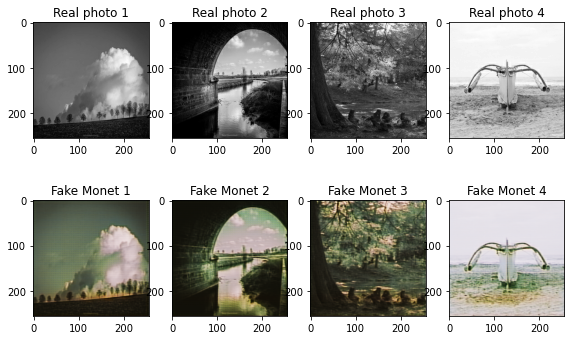

Epoch 7/18
100/100 [==============================] - 51s 512ms/step - gen_total_loss: 7.8121 - gen_gan_loss: 1.9821 - gen_l1_loss: 0.0583 - disc_loss: 0.7568

Epoch 00007: saving model to checkpoint_color.h5
5 generated examples


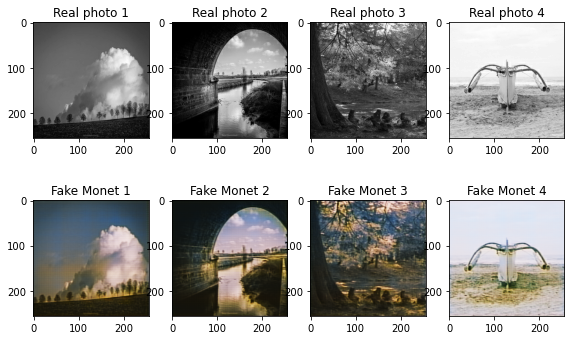

Epoch 8/18
100/100 [==============================] - 41s 415ms/step - gen_total_loss: 6.5315 - gen_gan_loss: 1.8011 - gen_l1_loss: 0.0473 - disc_loss: 0.7342

Epoch 00008: saving model to checkpoint_color.h5
5 generated examples


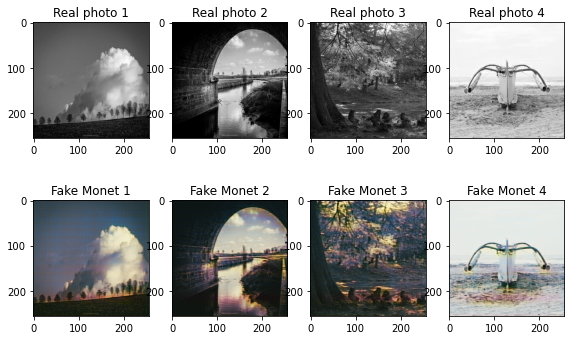

Epoch 9/18
100/100 [==============================] - 46s 456ms/step - gen_total_loss: 7.2007 - gen_gan_loss: 1.8348 - gen_l1_loss: 0.0537 - disc_loss: 0.7195

Epoch 00009: saving model to checkpoint_color.h5
5 generated examples


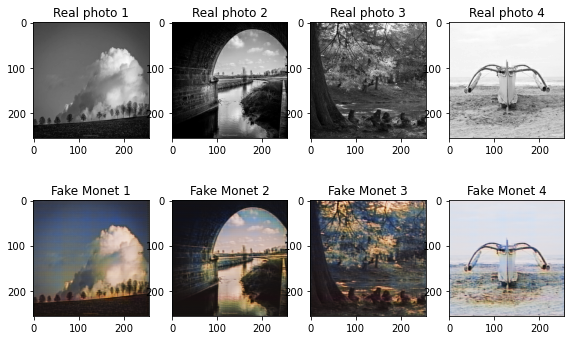

Epoch 10/18
 15/100 [===>..........................] - ETA: 40s - gen_total_loss: 6.6337 - gen_gan_loss: 2.1354 - gen_l1_loss: 0.0450 - disc_loss: 0.8535

KeyboardInterrupt: 

In [165]:
h=gan_model.fit(photo_ds,epochs=18,steps_per_epoch=100,callbacks=[model_checkpoint_callback,ShowExamples()])

In [26]:
print(h.history.keys())


dict_keys(['gen_total_loss', 'gen_gan_loss', 'gen_l1_loss', 'disc_loss'])


## Plotting losses

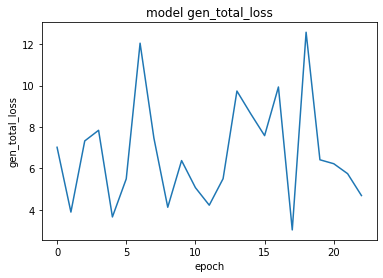

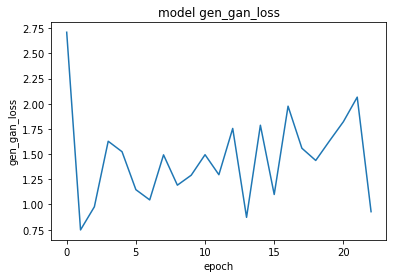

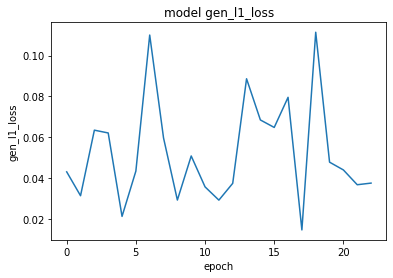

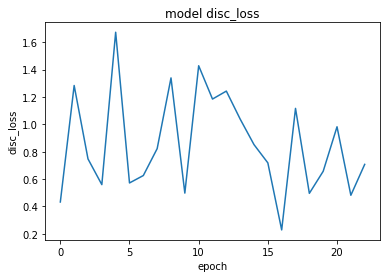

In [168]:
# summarize history for accuracy
for keys in h.history.keys():
    plt.plot(h.history[keys])
    
    plt.title('model '+keys)
    plt.ylabel(keys)
    plt.xlabel('epoch')
    
    plt.show()
    

# Visualize our generated photos

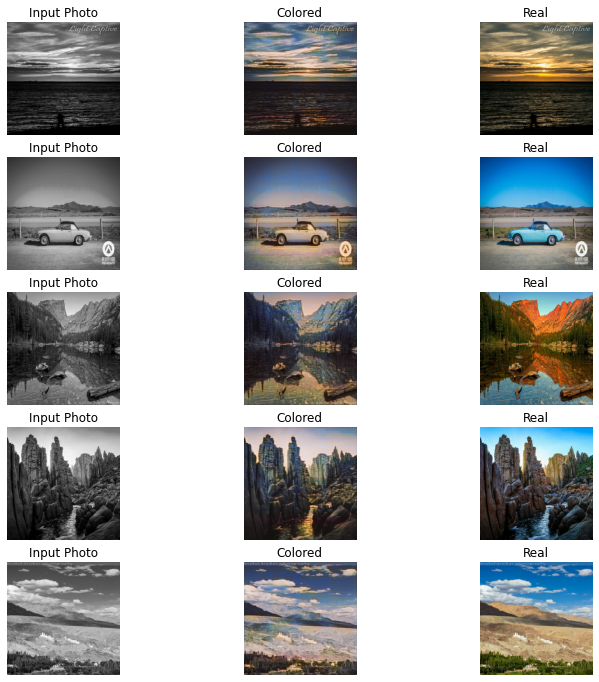

In [39]:
_, ax = plt.subplots(5, 3, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(15).skip(10)):
    real=img[1][0].numpy()
    real=(real* 127.5 + 127.5).astype(np.uint8)
    prediction = generator(img[0], training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img[0][:,:,0],cmap="gray")
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(real)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Colored")
    ax[i, 2].set_title("Real")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

## Testing on images from net

(256, 256, 3)


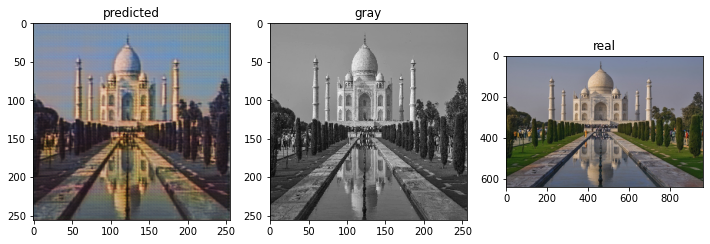

In [48]:




image1=plt.imread("taj.jpg")
image=image1.copy()


from PIL import Image
file_data = Image.open('taj.jpg')
file_data = file_data.convert('RGB') # conversion to RGB
image=np.array(file_data)


image=tf.image.resize(image,[256,256])
image = (tf.cast(image, tf.float32) / 127.5) - 1
image = tf.reshape(image, [*IMAGE_SIZE, 3])
image = tf.image.rgb_to_grayscale(image)
image=image[:,:,0]
image=np.expand_dims(image,axis=-1)

filling=tf.random.normal((256,256,2), mean=0.0, stddev=0.05, dtype=tf.dtypes.float32, seed=None, name=None)
image = tf.concat([image,filling],axis=2)

image=np.expand_dims(image,axis=0)

prediction = generator(image, training=False)[0].numpy()
prediction = (prediction * 0.5 + 0.5)
print(prediction.shape)
plt.figure(figsize=(12, 12))
plt.subplot(131)
plt.title("predicted")
plt.imshow(prediction)
plt.subplot(132)
plt.title("gray")
plt.imshow(image[0,:,:,0]*0.5+0.5,cmap="gray")
plt.subplot(133)
plt.title("real")
plt.imshow(image1)

# Save files

In [ ]:
i = 1
for img in photo_ds:
    prediction = style_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1
    if (i==100):
        break

In [ ]:
import shutil
shutil.make_archive("images", 'zip', "images")

## Conclusion

The results are satisfying given the input being grayscale, but we can clearly see a yellow tint on the outputs.
For a better improvement, we could try training the model for a longer period (on my machine I opted for a period of 4 hours using an RTX 2060) and also playing on hyperparameters such as the learning rate, changing the loss and optimizer functions.